Process snow sensor data. This takes in snow_scraped_df.pkl, and outputs a cleaner dataframe of snowfall data in sr.df.

In [1]:
import pickle as pkl
import pandas as pd

In [3]:
snow_df = pkl.load(open( "snow_scraped_df.pkl", "rb" ) )

In [4]:
# limit to points south of Reno, NV. 39.5296° N, 119.8138° W
# only keep useful values
mask = snow_df['st_lat'] < 39.5296
points = snow_df[mask].drop_duplicates(subset='st_code')[['st_lat','st_lon']]
sensors_df = snow_df[mask][['st_code','date','elev_ft','today_in','st_lat','st_lon']]

In [5]:
# see what percentage of each station has missing data
sensors_grouped = sensors_df.groupby('st_code')
sensors_grouped.groups.keys()
null_list = []
for g in sensors_grouped.groups.keys():
    number_null = sum(pd.isnull(sensors_grouped.get_group(g)['today_in']))
    percent_null = number_null/len(sensors_grouped.get_group(g)['today_in'])
    print('station', g, 'null:', percent_null*100, number_null)
    if percent_null > 0:
        null_list.append(g)

station agp null: 0.0 0
station alp null: 0.0 0
station bcb null: 100.0 61
station bch null: 0.0 0
station bgp null: 0.0 0
station bim null: 0.0 0
station blc null: 0.0 0
station bld null: 0.0 0
station blk null: 0.0 0
station bls null: 0.0 0
station bmw null: 0.0 0
station bsh null: 0.0 0
station bsk null: 0.0 0
station cap null: 0.0 0
station cbt null: 100.0 61
station chm null: 0.0 0
station chp null: 0.0 0
station crl null: 100.0 61
station csl null: 0.0 0
station csv null: 0.0 0
station cwd null: 100.0 61
station cxs null: 0.0 0
station dan null: 0.0 0
station ddm null: 0.0 0
station dpo null: 0.0 0
station ebb null: 0.0 0
station ep5 null: 0.0 0
station fdc null: 0.0 0
station fll null: 0.0 0
station frn null: 0.0 0
station frw null: 0.0 0
station gem null: 0.0 0
station gin null: 100.0 61
station gks null: 0.0 0
station gnf null: 0.0 0
station gnl null: 0.0 0
station grm null: 0.0 0
station grv null: 100.0 61
station hgm null: 0.0 0
station hhm null: 0.0 0
station hnt null: 0.0 

In [6]:
# drop stations in null_list
for st in null_list:
    sensors_df = sensors_df.loc[sensors_df['st_code']!=st]

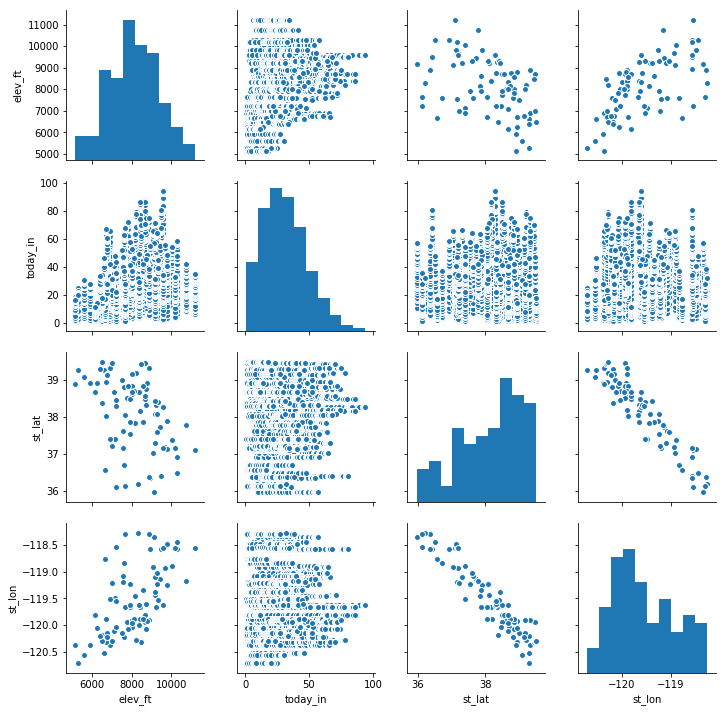

In [7]:
# look at elevation distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(sensors_df)
plt.show()

#### Try randomforest to predict today_in

In [8]:
sensors_df.columns

Index(['st_code', 'date', 'elev_ft', 'today_in', 'st_lat', 'st_lon'], dtype='object')

Generate train/test split based on station location



In [48]:
from numpy.random import randint

sensors_g = sensors_df.groupby('st_code')
train_df, test_df = [], []
for g,grp in sensors_g:
    if randint(0,3) == 0:
        test_df.append(grp)
    else:
        train_df.append(grp)
        
test_df = pd.concat(test_df)
train_df = pd.concat(train_df)

X_train = train_df.drop(['st_code','today_in'], axis=1)
X_test = test_df.drop(['st_code','today_in'], axis=1)

X_train['date'] = X_train['date'].map(lambda d: d.value)
X_test['date'] = X_test['date'].map(lambda d: d.value)

y_train = train_df['today_in']
y_test = test_df['today_in']

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# may have to log(today_in) to normalize it, but trying without it first
#from sklearn.preprocessing import StandardScaler

# scaling not needed for rf
# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)


rfc = RandomForestRegressor(n_estimators = 500, max_depth = 3)
rfc.fit(X_train, y_train)

y_test_predict = rfc.predict(X_test)
y_train_predict = rfc.predict(X_train)

print('R2 score  ', rfc.score(X_test, y_test))
print('mae (inches) train ', mean_absolute_error(y_train, y_train_predict))
print('mae (inches) test  ', mean_absolute_error(y_test, y_test_predict))


R2 score   0.475200847612
mae (inches) train  8.61762584545
mae (inches) test   9.06127198123


Not very accurate, needs more features.

In [95]:
rfc.feature_importances_

array([  6.20414375e-01,   3.79457082e-01,   0.00000000e+00,
         1.28543013e-04])

In [96]:
X_train.columns

Index(['date', 'elev_ft', 'st_lat', 'st_lon'], dtype='object')

get elevation for aspect angle calculation


In [78]:
# https://maps.googleapis.com/maps/api/elevation/json?locations=39.7391536,-104.9847034&key=YOUR_API_KEY
with open('googleapikey.txt') as f:
    apikey = f.readline()
    

In [86]:
from requests import get

url = "https://maps.googleapis.com/maps/api/elevation/json?locations=39.7391536,-104.9847034&key=" + apikey

r = get(url=url)
results = r.json()['results'][0]

In [89]:
results['elevation']
# figure out stdev in area around
# figure out aspect angle, alt azimuth

{'elevation': 1608.637939453125,
 'location': {'lat': 39.7391536, 'lng': -104.9847034},
 'resolution': 4.771975994110107}

### Distances and elevation deltas from radar stations

In [12]:
# hard coded from 
# http://apollo.lsc.vsc.edu/classes/remote/lecture_notes/radar/88d/88D_locations.html
# given as deg min sec strings, annoying
st_coords = {}
st_coords['KBBX'] = (392946, 1213754, 167)
st_coords['KRGX'] = (394515, 1192744, 8299)
st_coords['KDAX'] = (383004, 1214040, 30)
st_coords['KMUX'] = (370919, 1215354, 3469)
st_coords['KHNX'] = (361851, 1193756, 243)
st_coords['KEYX'] = (350552, 1173339, 2757)
st_coords['KESX'] = (354204, 1145329, 4867)

def dms2deg(dms):
    dms = str(dms)
    deg = float(dms[:-4])
    minu = float(dms[:-2][-2:])
    sec = float(dms[-2:])
    
    return(deg + minu/60 + sec/3600)

st_coords = tuple(map(lambda s: (s,dms2deg(st_coords[s][0]),dms2deg(st_coords[s][1]), st_coords[s][2]), st_coords))

# station code, lat, long, elev_ft
st_coords = {s[0]:(s[1], -s[2], s[3]) for s in st_coords}
st_coords

{'KBBX': (39.49611111111111, -121.63166666666666, 167),
 'KDAX': (38.50111111111111, -121.67777777777778, 30),
 'KESX': (35.70111111111111, -114.8913888888889, 4867),
 'KEYX': (35.09777777777778, -117.56083333333333, 2757),
 'KHNX': (36.314166666666665, -119.63222222222221, 243),
 'KMUX': (37.155277777777776, -121.89833333333334, 3469),
 'KRGX': (39.75416666666667, -119.46222222222222, 8299)}

For each snow sensor location (84 items), calculate distance to all radar stations. Store station code, distance, and elev difference. Join on st_code.

Maybe later, store distance to all radars. Then do a weighted average of radar returns.

In [13]:
from geopy.distance import vincenty

def get_closest_radar(st_coords, loc):
    #print(loc)
    dist = 9e9
    for st in st_coords:
        #print(st)
        if vincenty(st_coords[st][:2], loc[:2]).km < dist:
            dist = vincenty(st_coords[st][:2], loc[:2]).km
            #print(st)
            closest_st = st
            
    elev_delta = loc[2] - st_coords[closest_st][2]
    return {'r_closest':closest_st.lower(), 'r_dist_km':dist, 'r_elev_delta_ft':elev_delta}

#get_closest_radar(st_coords, (36.3275, -119.6457, 0))

In [14]:
#list(map(lambda r: get_closest_radar(st_coords, tuple(r)), sensors_df[['st_lat', 'st_lon', 'elev_ft']]))
a = sensors_df[['st_lat', 'st_lon', 'elev_ft']].apply(lambda row: get_closest_radar(st_coords, tuple(row)), axis=1)

In [15]:
b = pd.DataFrame(a.tolist())
sensor_groups = b.groupby('r_closest')

In [16]:
for rdr in sensor_groups.groups:
    min_d = min(sensor_groups.get_group(rdr)['r_dist_km'])
    max_d = max(sensor_groups.get_group(rdr)['r_dist_km'])
    mean_d = sensor_groups.get_group(rdr)['r_dist_km'].mean()
    print(rdr, min_d, max_d, mean_d)
    # 230 km is max range

kbbx 83.0305995377 103.761248315 94.96069025349301
kdax 121.588793799 182.77334246 146.53190430388062
keyx 120.095915033 120.095915033 120.09591503332923
khnx 82.4769193314 178.800052699 128.49451726120805
krgx 52.9857036501 187.237730898 120.56850942921834


In [17]:
sr_df = sensors_df.reset_index().drop('index', axis=1).join(b)

final sensor and radar dataframes

In [ ]:
# how to pickle
# https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict

In [18]:
rdr_coords = pd.DataFrame.from_dict(st_coords, orient='index')
rdr_coords.columns = ['lat', 'long', 'elev_ft']

In [19]:
rdr_coords

,lat,long,elev_ft
KBBX,39.496111,-121.631667,167
KRGX,39.754167,-119.462222,8299
KDAX,38.501111,-121.677778,30
KMUX,37.155278,-121.898333,3469
KHNX,36.314167,-119.632222,243
KEYX,35.097778,-117.560833,2757
KESX,35.701111,-114.891389,4867


Pickle

In [21]:
sr_df.to_pickle('sr_df.pkl')
rdr_coords.to_pickle('rdr_coords.pkl')


In [26]:
srr_df = sr_df[sr_df['r_closest'] == 'khnx'].reset_index()

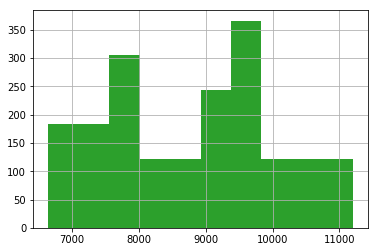

In [31]:
srr_df.elev_ft.hist()
plt.show()